E-commerce Recomentation System
===============================
This is a simple e-commerce recommendation system based on the [Amazon product data](http://jmcauley.ucsd.edu/data/amazon/). The data is stored in a [SQLite](https://www.sqlite.org/index.html) database. The system is built using [Python](https://www.python.org/) and [Jupyter Notebook](http://jupyter.org/). The system is built using the following libraries:
* [NumPy](http://www.numpy.org/)
* [Pandas](http://pandas.pydata.org/)
* [SciPy](https://www.scipy.org/)
* [Scikit-learn](http://scikit-learn.org/stable/)
* [Matplotlib](https://matplotlib.org/)
* [Seaborn](https://seaborn.pydata.org/)
* [Surprise](http://surpriselib.com/)
* [SQLAlchemy](https://www.sqlalchemy.org/)
* [Jupyter Notebook](http://jupyter.org/)
* [IPython](https://ipython.org/)
* [IPython-SQL]

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds

datasets

In [2]:
df = pd.read_csv('../datasets/ratings_Electronics.csv')
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
df = df.drop('timestamp', axis=1)
df_copy = df.copy(deep=True)

EDA - Exploratory Data Analysis
check for: 
* missing values
* outliers
* distribution of the data
* correlation between features
* Shape 
* Data Types

In [3]:
rows, columns = df.shape
print("Number of rows: ", rows)
print("Number of columns: ", columns)

Number of rows:  7824481
Number of columns:  3


Datatypes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


Missing Values analysis

In [6]:
#find number of missing values in each column
print("\nNumber of missing values in each column:\n", df.isnull().sum())


Number of missing values in each column:
 user_id    0
prod_id    0
rating     0
dtype: int64


Summary

In [7]:
df['rating'].describe().transpose()
#summary statistics of rating variable

count    7.824481e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

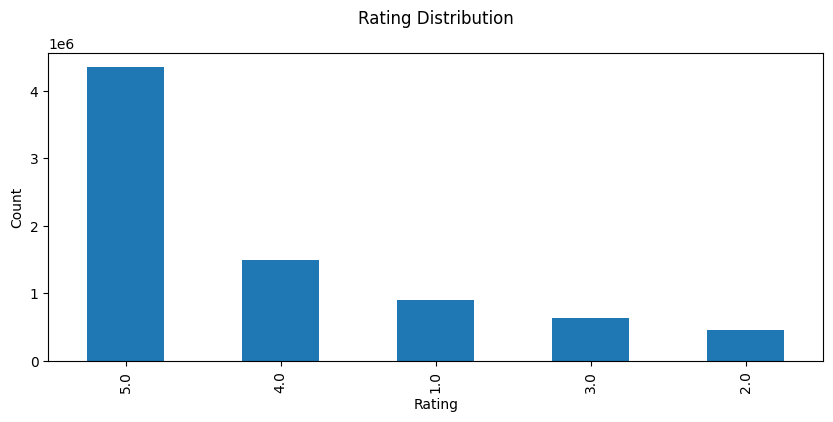

In [8]:
plt.figure(figsize=(10, 4))
df['rating'].value_counts().plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()